In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from wordcloud import WordCloud
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/Users/mement/Documents/Vietnamese Sentiment Analysis/data/data.csv')
df.head()

NameError: name 'pd' is not defined

In [5]:
# Kích thước và kiểu dữ liệu
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nDataset info:")
df.info()

NameError: name 'df' is not defined

In [5]:
# Độ dài text
df['text_length'] = df['content'].str.len()
print("Text length statistics:")
print(df['text_length'].describe())

# Số từ trong mỗi text
df['word_count'] = df['content'].str.split().str.len()
print("\nWord count statistics:")
print(df['word_count'].describe())

# Xem một vài samples
print("\nSample texts:")
for i in range(5):
    print(f"Text {i}: {df['content'].iloc[i]}")
    print(f"Label: {df['label'].iloc[i]}")
    print("-" * 50)

Text length statistics:
count    31436.000000
mean        43.914429
std         38.567678
min          1.000000
25%         19.000000
50%         31.000000
75%         55.000000
max        303.000000
Name: text_length, dtype: float64

Word count statistics:
count    31436.000000
mean        10.195699
std          8.620445
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         74.000000
Name: word_count, dtype: float64

Sample texts:
Text 0: Áo bao đẹp ạ!
Label: POS
--------------------------------------------------
Text 1: Tuyệt vời
Label: POS
--------------------------------------------------
Text 2: 2day ao khong giong trong
Label: NEG
--------------------------------------------------
Text 3: Mùi thơm,bôi lên da mềm da
Label: POS
--------------------------------------------------
Text 4: Vải đẹp, dày dặn
Label: POS
--------------------------------------------------


Label distribution:
label
POS    20093
NEG     6669
NEU     4698
Name: count, dtype: int64

Label proportions:
label
POS    0.638684
NEG    0.211983
NEU    0.149332
Name: proportion, dtype: float64


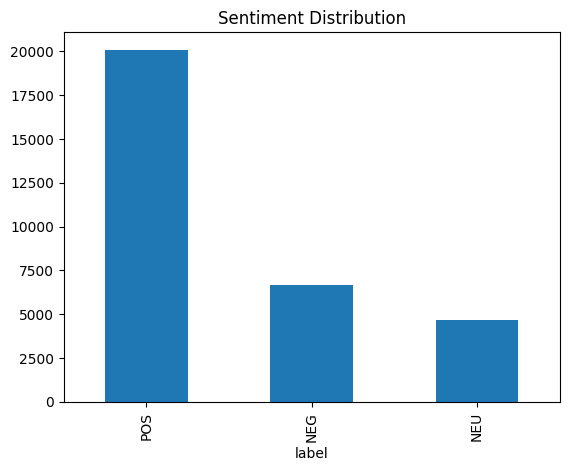

In [6]:
# Distribution của labels
print("Label distribution:")
print(df['label'].value_counts())
print("\nLabel proportions:")
print(df['label'].value_counts(normalize=True))

# Visualize
import matplotlib.pyplot as plt
df['label'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.show()

In [7]:
# Xem unique values trong cột start
print("Unique values in 'start' column:")
print(df['start'].value_counts())

# Mối quan hệ giữa start và label
print("\nCrosstab start vs label:")
print(pd.crosstab(df['start'], df['label']))

Unique values in 'start' column:
start
5    13286
4     6807
3     4698
1     3529
2     3140
Name: count, dtype: int64

Crosstab start vs label:
label   NEG   NEU    POS
start                   
1      3529     0      0
2      3140     0      0
3         0  4698      0
4         0     0   6807
5         0     0  13286


In [8]:
# Missing values
print("Missing values:")
print(df.isnull().sum())

# Duplicate rows
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Empty or very short texts
print(f"Empty texts: {(df['content'].str.len() == 0).sum()}")
print(f"Very short texts (<5 chars): {(df['content'].str.len() < 5).sum()}")

Missing values:
content        24
label           0
start           0
text_length    24
word_count     24
dtype: int64

Duplicate rows: 4259
Empty texts: 0
Very short texts (<5 chars): 287


In [9]:
# Text length theo sentiment
print("Average text length by sentiment:")
print(df.groupby('label')['text_length'].agg(['mean', 'median', 'std']))

# Word count theo sentiment
print("\nAverage word count by sentiment:")
print(df.groupby('label')['word_count'].agg(['mean', 'median', 'std']))

# Xem samples của từng loại
print("\nPositive samples:")
pos_samples = df[df['label'] == 'POS']['content'].head(3)
for i, text in enumerate(pos_samples):
    print(f"POS {i+1}: {text}")

print("\nNegative samples:")
neg_samples = df[df['label'] == 'NEG']['content'].head(3)
for i, text in enumerate(neg_samples):
    print(f"NEG {i+1}: {text}")

Average text length by sentiment:
            mean  median        std
label                              
NEG    42.355342    32.0  36.015348
NEU    37.770771    30.0  28.961452
POS    45.868214    32.0  41.097130

Average word count by sentiment:
            mean  median       std
label                             
NEG    10.101291     8.0  8.339889
NEU     8.968683     7.0  6.635986
POS    10.513896     7.0  9.084018

Positive samples:
POS 1: Áo bao đẹp ạ!
POS 2: Tuyệt vời
POS 3: Mùi thơm,bôi lên da mềm da

Negative samples:
NEG 1: 2day ao khong giong trong
NEG 2: tất sờn hết ca chưa dùng mà vay r
NEG 3: Cảm giác mua hàng bị hớ thật tệ


In [10]:
# Remove missing values
df_clean = df.dropna(subset=['content'])

# Remove duplicates
df_clean = df_clean.drop_duplicates(subset=['content'])

# Remove very short texts
df_clean = df_clean[df_clean['content'].str.len() >= 3]

print(f"Dataset after cleaning: {df_clean.shape}")

Dataset after cleaning: (26472, 5)


In [11]:
def preprocess_vietnamese_text(text):
    # Lowercase
    text = text.lower()
    
    # Handle common teen code
    text = re.sub(r'\b2day\b', 'hôm nay', text)
    text = re.sub(r'\bko\b', 'không', text)
    text = re.sub(r'\bk\b', 'không', text)
    text = re.sub(r'\br\b', 'rồi', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing
df_clean['content_processed'] = df_clean['content'].apply(preprocess_vietnamese_text)